In [1]:

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.stats.multitest as smm
#from sklearn.preprocessing import OneHotEncoder


In [2]:
with open("/Users/papiya/Desktop/CU_Capstone/Dataset/newmatrix.csv") as file:
    read_file = csv.reader(file)
    Data = list(line for line in read_file)
file.close()

In [3]:
Sample_Names = Data[0]
Site_Names = list(line[0] for line in Data[1:])
Beta_Matrix = list(list(map(float, line[1:])) for line in Data[1:])
beta_value= np.stack(Beta_Matrix)

In [4]:
m_value = np.log2(beta_value/(1 - beta_value))

In [5]:
m_value.shape

(450531, 322)

with open('/Users/papiya/Desktop/CU_Capstone/Dataset/bmiStatus.csv') as file:
    read_file = csv.reader(file)
    bmi_l = list(line for line in read_file)
file.close()

with open('/Users/papiya/Desktop/CU_Capstone/Dataset/age.csv') as file:
    read_file = csv.reader(file)
    age_l = list(line for line in read_file)
file.close()

with open('/Users/papiya/Desktop/CU_Capstone/Dataset/smoking_status.csv') as file:
    read_file = csv.reader(file)
    ss_l = list(line for line in read_file)
file.close()

bmi = np.array(list(item[1] for item in bmi_l)[1:]).astype(float)
age = np.array(list(item[1] for item in age_l)[1:]).astype(float)
ss = np.array(list(item[1] for item in ss_l)[1:]).astype(float)

In [6]:
import pandas as pd
from sklearn import preprocessing

df_age = pd.read_csv('/Users/papiya/Desktop/CU_Capstone/Dataset/age.csv')
df_age = df_age.drop(df_age.columns[0], axis=1)
df_bmi = pd.read_csv('/Users/papiya/Desktop/CU_Capstone/Dataset/bmiStatus.csv')
df_bmi = df_bmi.drop(df_bmi.columns[0], axis=1)
df_smok = pd.read_csv('/Users/papiya/Desktop/CU_Capstone/Dataset/smoking_status.csv')
df_smok = df_smok.drop(df_smok.columns[0], axis=1)
df_smok = df_smok[df_smok.columns[0]].astype('object')
s = pd.Series(list('012')) # one hot encoding 'smoking status'
df_smok = pd.get_dummies(df_smok)

# normalize the 'age' and 'bmi' columns

#def normalized(df):
    #x = df.values #returns a numpy array
    #min_max_scaler = preprocessing.MinMaxScaler()
    #x_scaled = min_max_scaler.fit_transform(x)
    #df = pd.DataFrame(x_scaled)
    #return df

#df_age = normalized(df_age)
#df_bmi = normalized(df_bmi)

# combine all the factors - age, bmi, smoking status
df_start = pd.concat([df_age, df_bmi, df_smok], axis=1, ignore_index=True)
df_start.columns = ['Age', 'BMI', 'Smoke_0', 'Smoke_1', 'Smoke_2']

df_start.head(2)

#enc = OneHotEncoder()
#enc.fit(ss)

,Age,BMI,Smoke_0,Smoke_1,Smoke_2
0,42.69,18.7,0,0,1
1,67.75,35.9,1,0,0


In [7]:
df = df_start.drop('Smoke_0', axis = 1)

#df['Smoke_0'] = 0.0
df.head(2)

,Age,BMI,Smoke_1,Smoke_2
0,42.69,18.7,0,1
1,67.75,35.9,0,0


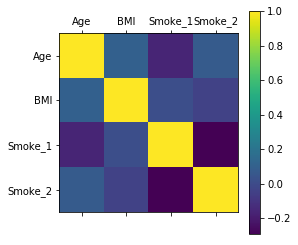

In [126]:

%matplotlib inline

#check correlation

correlation_matrix = np.corrcoef(X.T)
#print(correlation_matrix) 

names = ['Age', 'BMI', 'Quit smoking', 'Smoking']
plt.matshow(df.corr())
plt.xticks( range(4), ('Age', 'BMI', 'Smoke_1', 'Smoke_2') )
plt.yticks( range(4), ('Age', 'BMI', 'Smoke_1', 'Smoke_2') )
plt.colorbar()
plt.show()

In [10]:
# from Jun's code

sample_id = Sample_Names
site_id = Site_Names
beta_values = beta_value
m_values = m_value

X = df.values # convert to array
# X[:2]
X = X
#(X).shape  # X[1] shape is 4

(322, 4)

beta_range = np.linspace(0,1,200)
for i in range(beta_values.shape[1]):
    density = gaussian_kde(beta_values[:,i])
    #density.covariance_factor = lambda : .25
    #density._compute_covariance()
    plt.plot(beta_range, density(beta_range),'g')
plt.show()

In [11]:
lr_m = LinearRegression(fit_intercept= True, n_jobs= -1)  # data does not have zero mean so using True for Intercept
lr_m.fit(X, m_values.T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [54]:
(m_values.T).shape # y[1] shape is 450531


(322, 450531)

In [12]:
mse = np.sum((lr_m.predict(X) - m_values.T)**2 , axis = 0)/ float(X.shape[0] - X.shape[1])
"""
standard error is the square root of the variance of the estimate, which is the element in the diagnol of
the covariance matrix of the estimate. Use MSE as the estimated value of variance of the error. 
"""
se = np.array([np.sqrt(np.diagonal(mse[i] * np.linalg.inv(np.dot(X.T, X)) )) for i in range(mse.shape[0])]) 
t_m = lr_m.coef_/ se
p_m = 2 * (1 - stats.t.cdf(np.abs(t_m), X.shape[0] - X.shape[1])) # p_m shape is ((m_values.T).shape[1], X.shape[1]) => (450531,4)

#msr = np.sum((lr_m.predict(X) - np.mean(m_values.T, axis =0))**2, axis = 0) / float(X.shape[1] - 1)
#f_m = msr / mse
#pf_m = 1 - stats.f.cdf(np.abs(f_m), X.shape[1] -1, X.shape[0] - X.shape[1])

In [24]:
# extracting p-values for each factor across ALL sites

pval_age = [p_m[i][0] for i in range(len(p_m))]
pval_bmi = [p_m[i][1] for i in range(len(p_m))]
pval_smk1 = [p_m[i][2] for i in range(len(p_m))]
pval_smk2 = [p_m[i][3] for i in range(len(p_m))]
#pval_age[0:10]

In [42]:
## Applying multiple test correction
# separate out sites by significant factors

alpha = 0.05
method = 'fdr_tsbh'
p_signif = 0.01

pval_age_corr = smm.multipletests(pval_age, alpha=alpha, method=method)[1]
pval_bmi_corr = smm.multipletests(pval_bmi, alpha=alpha, method=method)[1]
pval_smk1_corr = smm.multipletests(pval_smk1, alpha=alpha, method=method)[1]
pval_smk2_corr = smm.multipletests(pval_smk2, alpha=alpha, method=method)[1]

age_loc = np.where(pval_age_corr < p_signif) # storing locations of sites significant with age
bmi_loc = np.where(pval_bmi_corr < p_signif)
smk1_loc = np.where(pval_smk1_corr < p_signif)
smk2_loc = np.where(pval_smk2_corr < p_signif)


bonferoni (array([     0,      3,      4, ..., 450462, 450463, 450464]),)

FDR Benjamini-Hochberg (array([     0,      1,      3, ..., 450512, 450514, 450515]),)

fdr_tsbh: 'FDR 2-stage Benjamini-Hochberg' (array([     0,      1,      2, ..., 450528, 450529, 450530]),) => selecting this method since mostly recommended for Genomics data. 

reference: http://physiology.med.cornell.edu/people/banfelder/qbio/resources_2009/Figueroa09_redacted.pdf
Most approaches for correcting for multiple comparisons work well for small number of parallel comparisons. But when tens of thousands of tests are performed most of these are too stringent (e.g. Bonferroni, Sidak, Holm’s). The most accepted methods for multiple testing correction
in the microarray field are:
- the False Discovery Rate (FDR) determination (Benjamini-Hochberg) ## WE ARE CHOOSING THIS ONE
- the use of permutations (Westfall-Young, SAM)

In [43]:
age_sites = list(site_id[i] for i in age_loc[0])
print(len(age_sites))

bmi_sites = list(site_id[i] for i in bmi_loc[0])
print(len(bmi_sites))

smk1_sites = list(site_id[i] for i in smk1_loc[0])
print(len(smk1_sites))

smk2_sites = list(site_id[i] for i in smk2_loc[0])
print(len(smk2_sites))
      


40518
31264
5
1


In [39]:
#result[0:20]

In [16]:
#result_list = result.tolist()
#result_list[0:9]

In [17]:
# Extract sites significant with each factor - age, bmi, smoking 1, smoking 2

#def generic_filter(x, TOKEN):
   # if x[1] == TOKEN:
     #   return x[0]

#age_list = list(map(lambda x: generic_filter(x, 'age'), result_list))
#age_filtered = list(filter(lambda x: x != None, age_list))

#bmi_list = list(map(lambda x: generic_filter(x, 'bmi'), result_list))
#bmi_filtered = list(filter(lambda x: x != None, bmi_list))

#smoking_1_list = list(map(lambda x: generic_filter(x, 'smoking factor 1'), result_list))
#smoking_1_filtered = list(filter(lambda x: x != None, smoking_1_list))

#smoking_2_list = list(map(lambda x: generic_filter(x, 'smoking factor 2'), result_list))
#smoking_2_filtered = list(filter(lambda x: x != None, smoking_2_list))

In [35]:
# write to disk the filtered lists

with open("/Users/papiya/Desktop/CU_Capstone/PSresults/p01_age_filtered.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in age_sites:
        writer.writerow([item,])

with open("/Users/papiya/Desktop/CU_Capstone/PSresults/p01_bmi_filtered.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in bmi_sites:
        writer.writerow([item,])
#print(bmi_filtered)


with open("/Users/papiya/Desktop/CU_Capstone/PSresults/p01_smoking_1_filtered.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in smk1_sites:
        writer.writerow([item,])
#print(smoking_1_filtered)


with open("/Users/papiya/Desktop/CU_Capstone/PSresults/p01_smoking_2_filtered.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in smk2_sites:
        writer.writerow([item,])

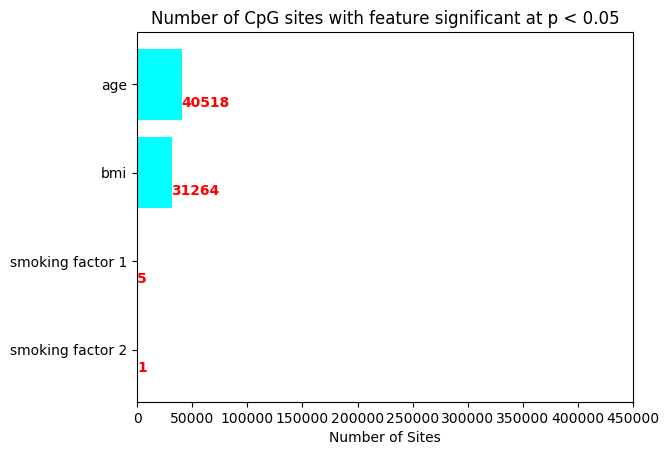

In [44]:
###### Visualization

plt.rcdefaults()
fig, ax = plt.subplots()

Features = ['age', 'bmi', 'smoking factor 1', 'smoking factor 2']
y_pos = np.arange(len(Features))
performance = np.array([len(age_sites), len(bmi_sites), len(smk1_sites), len(smk2_sites)])
#error = np.random.rand(len(people))

ax.barh(y_pos, performance, align='center',
        color='cyan')
for i, v in enumerate(performance):
    #ax.text(v + 25, i + .25, str(round(v/len(m_value), 2)), color='red', fontweight='bold')
    ax.text(v + 25, i + .25, str(v), color='red', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(Features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 450000))
ax.set_xlabel('Number of Sites')
ax.set_title('Number of CpG sites with feature significant at p < 0.05')

plt.show()

In [ ]:
labels = ['smoking factor 0 - never smoked', 'smoking factor 1 - smoked but quit', 'smoking factor 2 - smoking']
x = df_start.Smoke_0.value_counts()[1]
y = df_start.Smoke_1.value_counts()[1]
z = df_start.Smoke_2.value_counts()[1]
sizes = [x, y, z]
colors = ['gold', 'yellowgreen', 'lightskyblue']
#explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=140)
 
plt.axis('equal')
plt.title('Smoking status of 322 patients', color = 'green')
plt.show()


### CLUSTERING ###

In [73]:
# clustering within factor = Age

m_values_age = m_values[age_loc]
m_values_age
#beta_values_age = beta_values[age_loc]


array([[ 1.69872308,  1.53358213,  1.42294506, ...,  1.7768235 ,
         1.65553684,  1.40902904],
       [ 2.95398056,  3.00688049,  2.54756733, ...,  2.78350993,
         2.52984291,  2.72552192],
       [ 1.52121049,  2.35083489,  1.89277922, ...,  2.00030063,
         2.40675999,  2.02374429],
       ..., 
       [-3.88972059, -4.10386461, -3.72678076, ..., -3.88254929,
        -4.24433766, -4.28432306],
       [ 5.00970068,  5.73129812,  5.74582998, ...,  1.04699919,
         4.85974074,  0.95191644],
       [ 0.42338456,  6.82496483,  0.55411909, ...,  0.57312619,
         0.47846334,  0.68112917]])

In [104]:
# Compute clustering with Means

# clustering the CpG sites

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

n_clusters = 5
X = (m_values_age)
#X = (beta_values_age)
k_means = KMeans(init='k-means++', n_clusters=n_clusters)
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [84]:
#X.shape
my_members = labels == 2
X[my_members]
#my_members

array([[ 2.95398056,  3.00688049,  2.54756733, ...,  2.78350993,
         2.52984291,  2.72552192],
       [ 4.48117339,  3.45304072,  4.35426124, ...,  4.01088568,
         3.82129758,  3.98433773],
       [ 3.18651129,  2.57750959,  3.02210094, ...,  3.41974668,
         3.0934471 ,  3.58309262],
       ..., 
       [ 2.95029418,  2.5310205 ,  2.5839985 , ...,  2.79052841,
         3.02416742,  3.08734136],
       [ 3.22820675,  2.96146837,  2.61244792, ...,  2.6970085 ,
         3.37194454,  2.99586445],
       [ 5.00970068,  5.73129812,  5.74582998, ...,  1.04699919,
         4.85974074,  0.95191644]])

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


def plot_clusters(data, algorithm, args, kwds):
    
    labels = algorithm(*args, **kwds).fit_predict(data)
    
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    

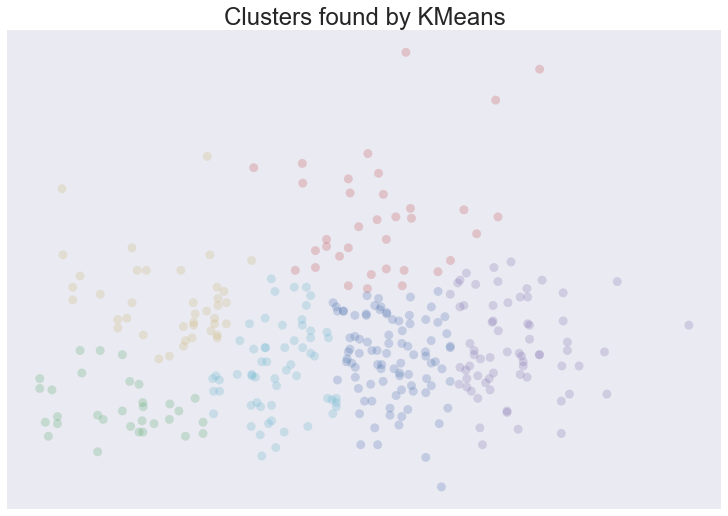

In [128]:
# k means

plot_clusters(X, cluster.KMeans, (), {'n_clusters':6})

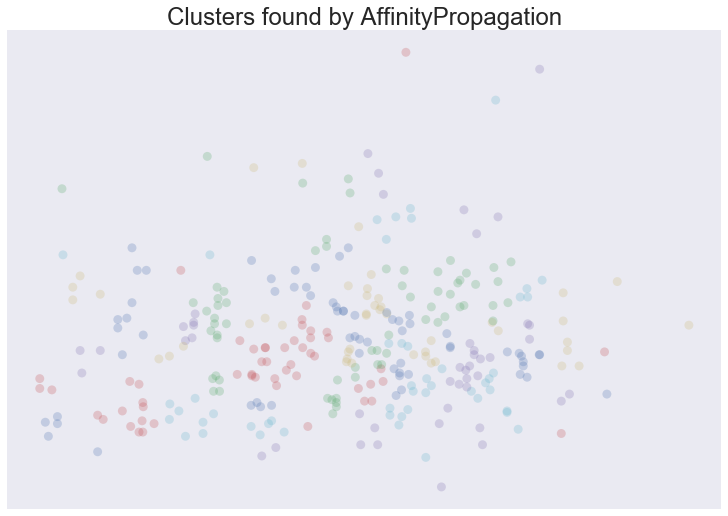

In [129]:
plot_clusters(Xplot_clusters(data, cluster.MeanShift, (0.175,), {'cluster_all':False}), cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

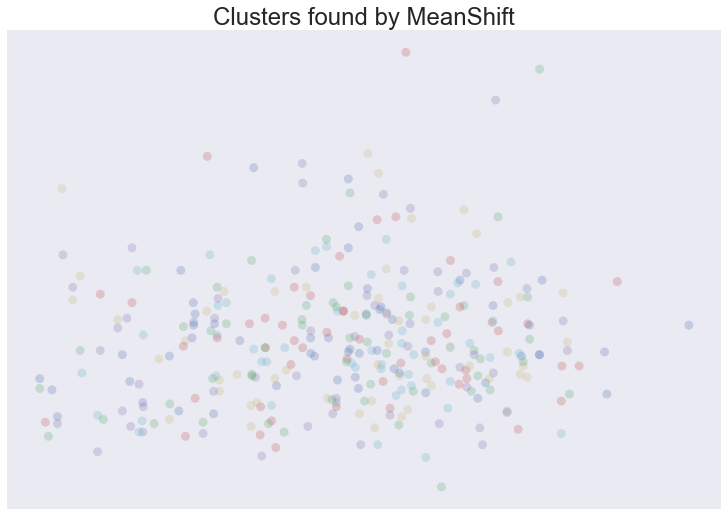

In [130]:
plot_clusters(X, cluster.MeanShift, (0.175,), {'cluster_all':False})

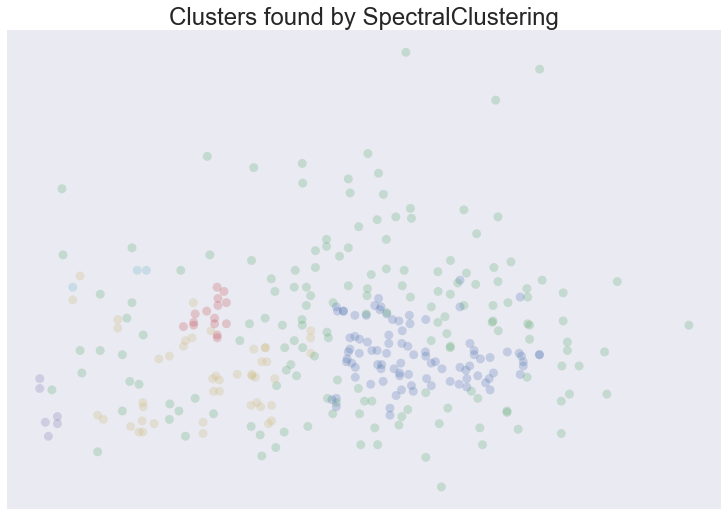

In [131]:
plot_clusters(Xplot_clusters(data, cluster.DBSCAN, (), {'eps':0.025}), cluster.SpectralClustering, (), {'n_clusters':6})

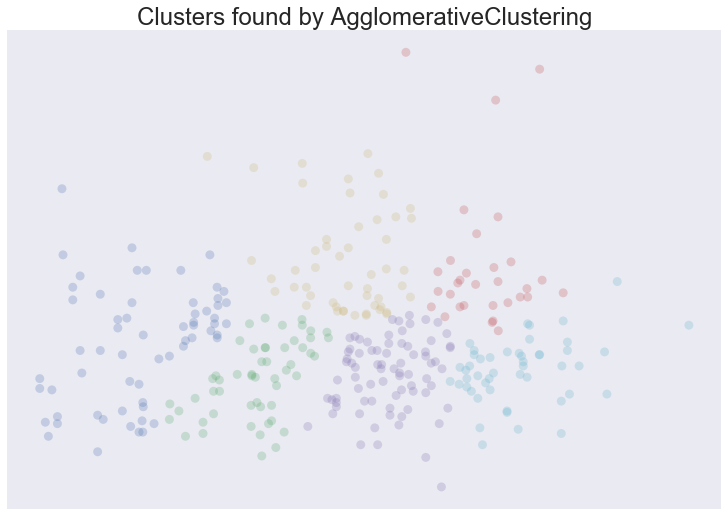

In [134]:
plot_clusters(X, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

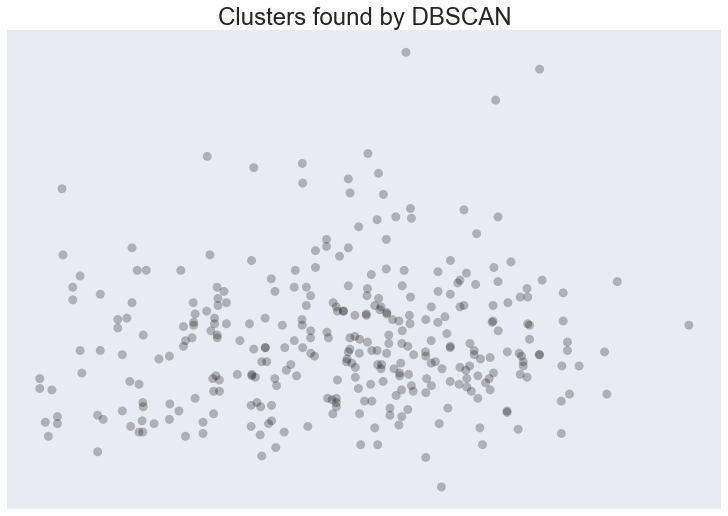

In [133]:
plot_clusters(X, cluster.DBSCAN, (), {'eps':0.025})

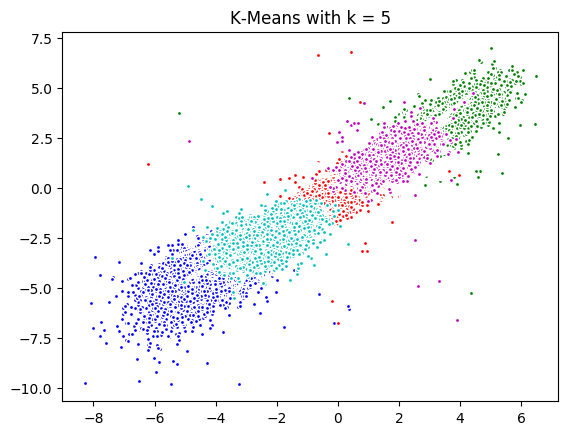

In [105]:
# Plot results

centroid = k_means.cluster_centers_
labels = k_means.labels_

#k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
#k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

fig = plt.figure()
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = colors[0:n_clusters]

#ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroid[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            #markeredgecolor='k', markersize=6)
#ax.set_title('KMeans')
#ax.set_xticks(())
#ax.set_yticks(())
plt.title('K-Means with k = 5')
plt.show()




In [96]:
print(labels)

[15 11  7 ..., 13  4  3]


In [82]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [3, 5, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    
    # The silhouette coefficient can range from -1, 1 
    #ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks(())  # Clear the yaxis labels / ticks
    ax1.set_xticks(())

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

KeyboardInterrupt: 